In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pytrade
import matplotlib.pyplot as plt
import datetime

pd.options.display.float_format = '{:,.3f}'.format

In [2]:
%%time
raw = pytrade.get_data(reload = False)
ratios = pytrade.calculate_ratio(raw)
output = pytrade.analysis_1.run(ratios)
output.sort_values(by="short_term_metric",ascending=False,inplace=True)
my_shortterm = output.loc[["DG","BLK","DXCM","QRVO","AMD","LULU","MSFT"]]
my_longterm = output.loc[["AMGN","AAPL","UNH","NLOK","WMT","OKE","INTC","KLAC","REGN"]]
shortterm_portfolio = pytrade.Portfolio.load("st_portfolio", raw)
longterm_portfolio = pytrade.Portfolio.load("lt_portfolio", raw)
output

Wall time: 157 ms


,latest,three_wk_high,three_wk_low,three_m_high,three_m_low,one_yr_high,one_yr_low,three_wk_range,three_m_range,one_yr_range,short_term_stochastic,long_term_stochastic,st_potential,lt_potential,short_term_metric,long_term_metric
JD,61.710,68.717,61.710,68.717,47.006,68.717,29.547,0.000,0.677,0.821,0.821,0.144,0.114,0.114,1.000,0.353
MELI,956.620,"1,045.759",956.620,"1,045.759",644.245,"1,045.759",504.735,0.000,0.778,0.835,0.835,0.057,0.093,0.093,0.982,0.229
SPLK,199.020,213.346,199.020,213.346,145.808,213.346,118.197,0.000,0.788,0.849,0.849,0.062,0.072,0.072,0.963,0.194
PYPL,169.810,186.922,169.810,186.922,124.405,186.922,103.428,0.000,0.726,0.795,0.795,0.069,0.101,0.101,0.954,0.255
IDXX,339.200,348.045,339.200,348.045,296.616,348.045,255.028,0.000,0.828,0.905,0.905,0.077,0.026,0.026,0.946,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PVH,51.260,51.260,43.367,69.099,43.367,107.605,40.042,1.000,0.307,0.166,-0.834,-0.141,-0.145,-0.114,-1.063,-0.351
TPR,14.040,14.060,12.589,18.651,12.589,31.961,12.589,0.987,0.239,0.075,-0.912,-0.164,-0.103,-0.103,-1.074,-0.355
XRX,17.330,17.330,14.925,20.751,14.925,39.036,14.925,1.000,0.413,0.100,-0.900,-0.313,-0.139,-0.139,-1.119,-0.569
FTI,7.880,7.880,6.947,10.141,6.947,29.321,6.579,1.000,0.292,0.057,-0.943,-0.235,-0.116,-0.111,-1.126,-0.439


In [ ]:
output.sort_values(by="long_term_metric",ascending=False,inplace=True)
output

In [ ]:
my_longterm

In [ ]:
my_shortterm

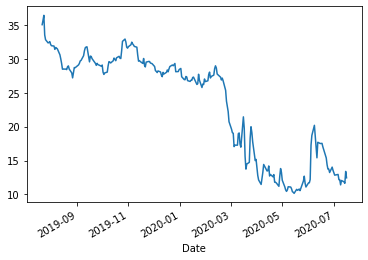

In [13]:
plt.close('all')
ratios["AAL"].tail(250).plot()

In [14]:
output.loc[["TSLA"]]

,latest,three_wk_high,three_wk_low,three_m_high,three_m_low,one_yr_high,one_yr_low,three_wk_range,three_m_range,one_yr_range,short_term_stochastic,long_term_stochastic,st_potential,lt_potential,short_term_metric,long_term_metric
TSLA,"1,500.640","1,559.456","1,025.610","1,559.456",796.671,"1,559.456",238.758,0.890,0.923,0.955,0.066,0.033,0.039,0.039,0.127,0.105


In [ ]:
longterm_portfolio.report()

In [ ]:
longterm_portfolio.current_value()

In [ ]:
longterm_portfolio.market_current_value()

In [ ]:
shortterm_portfolio.current_value()

In [ ]:
shortterm_portfolio.market_current_value()

In [ ]:
# shortterm_portfolio.deposit(7174.44, datetime.date(2020, 6, 22))
# shortterm_portfolio.buy("PKI", 73, 7174.44, datetime.date(2020, 6, 22))
# shortterm_portfolio.deposit(787.11, datetime.date(2020, 6, 23))
# shortterm_portfolio.buy("ZBRA", 3, 787.11, datetime.date(2020, 6, 23))
# shortterm_portfolio.deposit(7535.5, datetime.date(2020, 6, 24))
# shortterm_portfolio.buy("QRVO", 70, 7535.5, datetime.date(2020, 6, 24))
# shortterm_portfolio.deposit(5505.65, datetime.date(2020, 7, 2))
# shortterm_portfolio.buy("DG", 29, 5505.65, datetime.date(2020, 7, 2))
# shortterm_portfolio.sell("PKI", 73, 7311.52, datetime.date(2020, 7, 7))
# shortterm_portfolio.buy("BLK", 13, 7161.18, datetime.date(2020, 7, 7))
# shortterm_portfolio.sell("ZBRA", 3, 793, datetime.date(2020, 7, 14))
# shortterm_portfolio.buy("DXCM", 2, 780, datetime.date(2020, 7, 14))

In [ ]:
# longterm_portfolio.deposit(2024.7, datetime.date(2020, 6, 22))
# longterm_portfolio.buy("INTC", 34, 2024.7, datetime.date(2020, 6, 22))
# longterm_portfolio.deposit(4988.58, datetime.date(2020, 7, 8))
# longterm_portfolio.buy("OKE", 183, 4988.58, datetime.date(2020, 7, 8))
# longterm_portfolio.deposit(5993.46, datetime.date(2020, 7, 16))
# longterm_portfolio.buy("NLOK", 297, 5993.46, datetime.date(2020, 7, 16))

In [ ]:
shortterm_portfolio.save()
longterm_portfolio.save()

In [3]:
shortterm_portfolio.calc_rate_of_return()

1.7198681526142372

In [4]:
shortterm_portfolio.calc_market_rate_of_return()

1.944433730638401

In [ ]:
raw["^GSPC"][datetime.date.today()]

In [ ]:
raw